# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 8 -- Solution

**Issued**: Tuesday, June 18, 2024, 1:00 pm

**Due**: Tuesday, June 25, 2024, 1:00 pm

# MRI reconstruction with diffusion models

In this homework, we consider reconstructing (complex) images from undersampled MRI measurents with a diffusion model. More specifically, we implement the *variational approach* (we further discussed Langevin and posterior sampling in the lecture).

**MRI**: The measurements $\mathbf{y} \in \mathbb{C}^m$ acquired by the MRI scanner of the unknown $\mathbf{x} \in \mathbb{C}^n$ can be described by:
$$
\mathbf{y} = \mathbf{M} \mathbf{F} \mathbf{x} + \mathbf{z},
$$
where $\mathbf{M}$ is an under-sampling mask (see the discussion in the lecture notes, e.g. in Chapter 8), whose elements are $1$ if a measurement is taken and $0$ otherwise. Moreover, $\mathbf{F}$ is the two-dimensional discrete Fourier transformation, and $\mathbf{z}$ additive noise. Note, that this is a simplified description of MRI, since in practice there are multiple measurements $\mathbf{y}_i$ taken in parallel.

**Diffusion model**: You will perform reconstruction with a diffusion model $\epsilon_{\theta}(\mathbf{x}_t, t)$, where $t$ is a timestep in the diffusion process and $\mathbf{x}_t$ a corresponding noisy sample of the forward process. The diffusion provided to you is pre-trained on complex MRI knee images, by minimizing the diffusion model training objective:
$$
L(\theta) = \mathbb{E}_{\mathbf{x}, t \sim \mathcal{U}(0, 1000), \epsilon \sim \mathcal{N}(0, \mathbf{I})} [ \| \epsilon_{\theta}(\mathbf{x}_t, t) - \epsilon \|^2]
$$
where $\mathbf{x}_t = \sqrt{1 - \sigma_t^2} \mathbf{x} + \sigma_t \epsilon$. Here, the DDPM parametrization is used, with $\sigma_t^2$ as defined in the lecture.

**Task preview**: The homework consists of two tasks (detailed below).
 1. Visualize the forward diffusion process (for DDPM parametrization)
 2. Implement the variational loss for reconstruction images from an undersampled MRI measurement

# Introduction

In [1]:
# on colab (and locally) you might need to install fastmri library
#!pip install fastmri

In [4]:
import torch
from tqdm import tqdm
import fastmri.data
import fastmri.data.subsample
import fastmri.data.transforms as fdt
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import Tuple

In [5]:
device = "cuda:0"
data_sample_path = "data_sample.pt"
model_path = "model.pt"

use_colab = "colab" in str(get_ipython())
if use_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  # base_folder might need to be adapted, depending on where
  base_folder = '/content/drive/'
  data_sample_path = f'{base_folder}/{data_sample_path}'
  model_path = f'{base_folder}/{model_path}'

  # import base folder, such that we can use the unet python module
  import sys
  sys.path.append(f"{base_folder}")
# else assume that the files are locally available

## MRI inverse problem

In [6]:
# we choose an acceleration and a fixed mask_seed (you can also change the acceleration if you like)
acceleration = 4.0
mask_seed = 3

# we choose a random mask function, there are also other functions available
rnd_mask_func = fastmri.data.subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[acceleration], seed=mask_seed)

# forward transformation
def mri_trafo_fwd(x : torch.Tensor, mask_func = None):
    if mask_func is None:
        return fastmri.fft2c(x)
    else:
        mask, _ = mask_func(x.shape, seed=mask_seed)
        return fastmri.fft2c(x) * mask.to(device) + 0.0

# adjoint transformation
def mri_trafo_adjoint(y : torch.Tensor):
    return fastmri.ifft2c(y)

### Utils for visualization and evaluation

In [7]:
# Since our MRI sample has relatively low contrast, we increase the contrast when visualizing the results
def normalize_clamp(im, sigma_clamp=3):
    im = (im-im.mean()) / im.std()
    return im.clamp(-sigma_clamp,sigma_clamp)

# We evaluate the reconstruction quality in terms of (complex) PSNR
def psnr(rec, target):
    mse = (rec  - target).square().mean()
    data_range = torch.max(target) - torch.min(target)
    return 20*torch.log10(data_range) - 10*torch.log10(mse)

## Load and visualize data sample

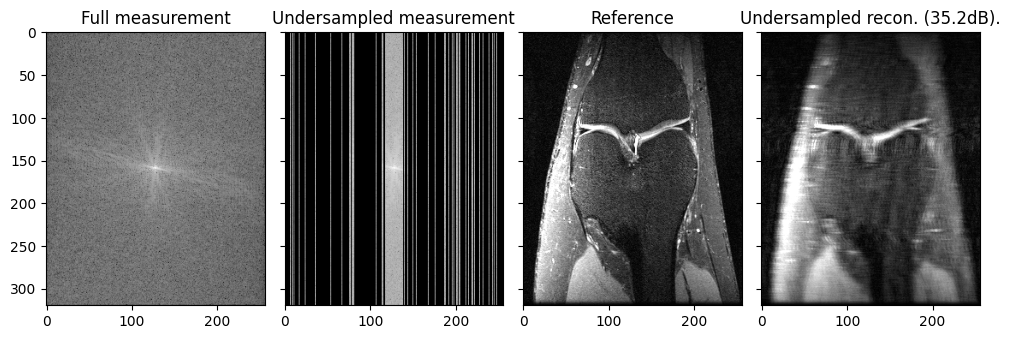

In [8]:
# the data files contain the fully-sampled kspaces
kspace = torch.load(data_sample_path).to(device).unsqueeze(dim=0)
# we obtain the complex target / reference image from the ifft
complex_target = fastmri.ifft2c(kspace)

# we simulate an undersampled measurement by applying the forward trafo (with the random mask func)
masked_kspace = mri_trafo_fwd(complex_target, rnd_mask_func)

# a simple reconstruction can be obtained by the adjoint trafo
pseudorec = mri_trafo_adjoint(masked_kspace)

# as first row, we plot the kspace (in logarithmic scale)
fig, ax = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(10, 4*10))
ax[0].imshow(  (kspace.squeeze(0).norm(dim=-1) + 1e-9).log().cpu(), cmap='gray')
ax[0].set_title("Full measurement")
ax[1].imshow(  (masked_kspace.squeeze(0).norm(dim=-1) + 1e-9).log().cpu(), cmap='gray')
ax[1].set_title("Undersampled measurement")

# and the magnitude of the reference / pseudoinverse reconstruction
ax[2].set_title("Reference")
ax[2].imshow(normalize_clamp(complex_target.norm(dim=-1).squeeze().cpu()), cmap="gray")
ax[3].set_title(f"Undersampled recon. ({psnr(pseudorec, complex_target):.1f}dB).")
ax[3].imshow(normalize_clamp(fastmri.complex_abs(pseudorec).squeeze(0).cpu()), cmap="gray")

fig.tight_layout()

## Loading the diffusion model

The U-Net architecture used in this homework is more advanced compared to the U-Net models from the previous homeworks. One could also train a diffusion model with the simpler version, but the added attention layers allow for increased performance. Moreover, in contrast to previous exercises, the network does also take into account the time step in the diffusion model, in addition to the image.

In [9]:
from diffmodels.unet import UNetModel
base_config = {
    "num_heads": 4,                       # nr of attention heads
    "num_res_blocks": 4,                  # nr of residual blocks per stage
    "attention_resolutions": [],          # resolution at which we have attention (only bottleneck)
    "use_scale_shift_norm": True,         # type of timestep conditioning
    "resblock_updown": True,              # we use AvgPooling and nearest neighbor interpolation for up/downsampling
    "channel_mult" : tuple([1, 2, 2, 2]), # channel multiplier per stage
    "in_channels" : 2,                    # two channels (since we our images have real and imaginary parts)
    "out_channels" : 2,                   # see above
    "model_channels" : 32                 # nr of channels in the first layer
}
diff_unet = UNetModel(**base_config)
diff_unet.load_state_dict(torch.load(model_path, map_location=device))
diff_unet = diff_unet.to(device)

# Task 1: Diffusion model forward process

As preparation for the reconstruction method, we need to work out the diffusion model's forward process. For this homework, we consider the DDPM parametrization with the $\beta_i$'s increasing linearly from $\beta_{min}=0.0001$ to $\beta_{max}=0.02$ with $T = 1000$ steps.

**Task**: Implement the diffusion model forward process $q(\mathbf{x}_t | \mathbf{x}_0)$ and visualize the forward process.

In [10]:
# this should return x_t, z (with z the Gaussian noise used later in the homework)
def diffusion_ddpm_forward(x0 : torch.Tensor, t : torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    raise NotImplementedError("Implement the forward process q(x_t | x_0) for a given timestep t!")

#### Solution Task 1:

In [11]:
##############################################
## Solution task 1
##############################################
beta_min = 0.0001
beta_max = 0.02
T = 1000

betas = torch.cat( [torch.zeros(1), torch.linspace(beta_min, beta_max, T)] ).to(device)
sigmas = (1.0 - (1 - betas).cumprod(dim=0)).sqrt()

def diffusion_ddpm_forward(x0, t):
    noise = torch.randn_like(x0)
    return torch.sqrt(1 - sigmas[t]**2) * x0 + sigmas[t] * noise, noise
##############################################

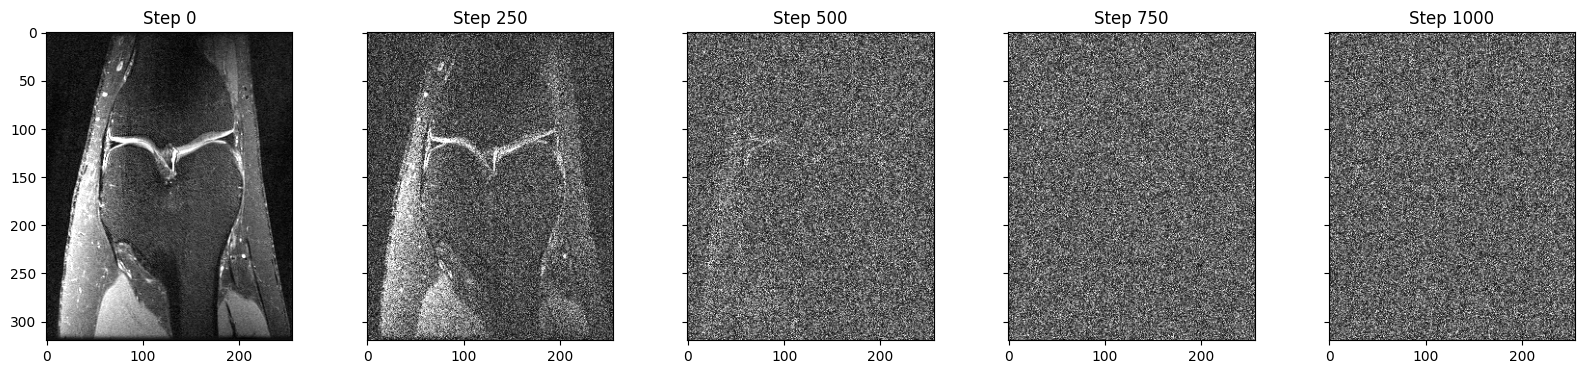

In [12]:
# visualization
nr_samples = 5
# the diffusion model is trained on normalized data
x0 = (complex_target - complex_target.mean()) / complex_target.std()
fig, ax = plt.subplots(ncols=nr_samples, sharey=True, figsize=(nr_samples*4, 4))
for i in range(nr_samples):
    timestep = (1000 // (nr_samples - 1)) * i
    x = diffusion_ddpm_forward(x0, timestep)[0]
    ax[i].imshow(normalize_clamp(fastmri.complex_abs(x).squeeze(0).cpu()), cmap="gray")
    ax[i].set_title(f"Step {timestep}")

# Task 2: MRI reconstruction with diffusion models

In the following, you can see the method we use for our reconstruction. We formulate the reconstruction as an optimization problem, where the objective function `var_loss` is minmized with respect to the unknown image $\mathbf{x}$. We employ gradient descent (Adam), and scale our measurements (and data) such that our reconstruction has approximately zero mean and unit variance. This is analogous to how we normalize data in end-to-end learning setups. After taking a look at the reconstruction skeleton, and a helper function for visualization, your task is to implement the reconstruction objective `var_loss`.

In [13]:
# minimizes the var_loss objective using gradient descent
def perform_reconstruction(var_loss, measurement, complex_target, lr = 0.1, iterations = 200, seed=0, random_init=False):
    # set seed for reproducibility
    torch.manual_seed(seed) # set the seed for experiment reproducibility

    # we scale the observation so that we can use standard learning rates
    scaling_factor = 2*math.sqrt(float(np.prod(measurement.shape).item())) / measurement.detach().cpu().norm()

    # we use the (scaled) pseudoinverse to initialize reconstruction (but can also start from random)
    x0_scaled = fastmri.ifft2c(measurement * scaling_factor)

    # we initialize the reconstruction from random (or from the pseudoinverse which is faster)
    if random_init:
        xinit = torch.randn_like(x0_scaled)
    else:
        xinit = x0_scaled.clone()

    # we use a torch parameter and Adam optimizer
    rec = torch.nn.Parameter(xinit, requires_grad=True)
    optimizer = torch.optim.Adam([rec], lr=lr)

    # perform gradient descent to minimize the var_loss objective
    with tqdm(range(iterations), desc='reconstructing') as pbar:
        for _ in pbar:
            optimizer.zero_grad()
            # here we calculate the loss wrt to the objective function you implement
            loss = var_loss(rec, measurement * scaling_factor)
            loss.backward()
            optimizer.step()
            pbar.set_postfix({'psnr': psnr(rec / scaling_factor, complex_target).item(), 'loss': loss.item()})
    return rec / scaling_factor

# a helper function to visually compare the results
def plot_reconstruction(rec, complex_target):
    fig, ax = plt.subplots(ncols=3, figsize=(10, 30), sharey=True)
    ax[0].imshow(normalize_clamp(complex_target.norm(dim=-1).squeeze().cpu()), cmap="gray")
    ax[0].set_title("Reference slice")
    ax[1].imshow(normalize_clamp(pseudorec.cpu().squeeze().norm(dim=-1)), cmap="gray")
    ax[1].set_title(f"Pseudoinverse rec {psnr(pseudorec, complex_target).item():.1f}dB")
    ax[2].imshow(normalize_clamp(fastmri.complex_abs(rec).detach().cpu().squeeze(0)), cmap="gray")
    ax[2].set_title(f"Reconstruction {psnr(rec, complex_target).item():.1f}dB")
    fig.tight_layout()

**Task**: Implement the `variational_loss` as described in the lecture notes, and given by the following equation:
$$
    L(\mathbf{x}) = \| \mathbf{A} \mathbf{x} - \mathbf{y} \|^2 + \mathbb{E}_{t, \mathbf{\epsilon}} [ \lambda w(t) \| \epsilon_{\theta}(\mathbf{x}_t, t) - \mathbf{\epsilon} \|^2],
$$
where $\mathbf{A}$ refers to the forward map of the inverse problem, $\mathbf{y}$ is the (undersampled) measurement, and $\epsilon_{\theta}(\mathbf{z}, t)$ the pre-trained diffusion model. Note, that we rescaled the objective compared to the lecture notes, since we do not know the variance $\sigma^2$.


**Note**:
- The diffusion model (score model) treats the *complex channel* (real and imaginary part) as color channel, so you may need to swap the axes before applying the score model.
- Reuse the diffusion model forward process implemented in task 1, for obtaining the noisy samples
- Experiment with different *weighting functions* $w(t)$, you should obtain improved results compared to the PSNR of the pseudoinverse (for $\lambda = 0.1$).


In [14]:
# Implementation of the variational objective
# --------------------------------------------------------------
# It should depend on:
# - The parameters of the function (`rec`, `measurement`)
# - A regularization parameter `reg_strength` (the value $\lambda = 0.1$ works well), but you can experiment with other setttings as well
# - The diffusion U-Net model and the DDPM forward process (implemented in task 1)
# - The forward transformation `mri_trafo_fwd` of the MRI problem, with the correct masking function (you can also use the adjoint)
def variational_loss(x, measurement):
    raise NotImplementedError("Implement the variational loss here!")

In [16]:
##################################################
## Solution task 2
##################################################
reg_strength = 0.1

def data_consistency(x, measurement):
    return (measurement - mri_trafo_fwd(x, mask_func=rnd_mask_func)).square().sum()

def diffusion_loss(x):
    # The MRI data has shape (1, X, Y, 2) (with complex channel as last dimension)
    # but the diffusion model treats the complex channels as colors, i.e. expects (1, 2, X, Y)
    x = x.moveaxis(-1, 1)

    # first we sample a random timestep t ~ U(1, T)
    t = torch.randint(1, T,
        (x.shape[0],),
        device=x.device
    )

    # next, we sample a noise z \sim N(0, I)
    perturbed_x, z = diffusion_ddpm_forward(x, t)
    zhat = diff_unet(perturbed_x, t)

    # we calculate the L2 norm
    return (z - zhat).square().sum()

def variational_loss(x, measurement):
    return data_consistency(x, measurement) + reg_strength * diffusion_loss(x)

##################################################

### Reconstruction

reconstructing: 100%|██████████| 500/500 [00:59<00:00,  8.44it/s, psnr=38.4, loss=2.43e+3]


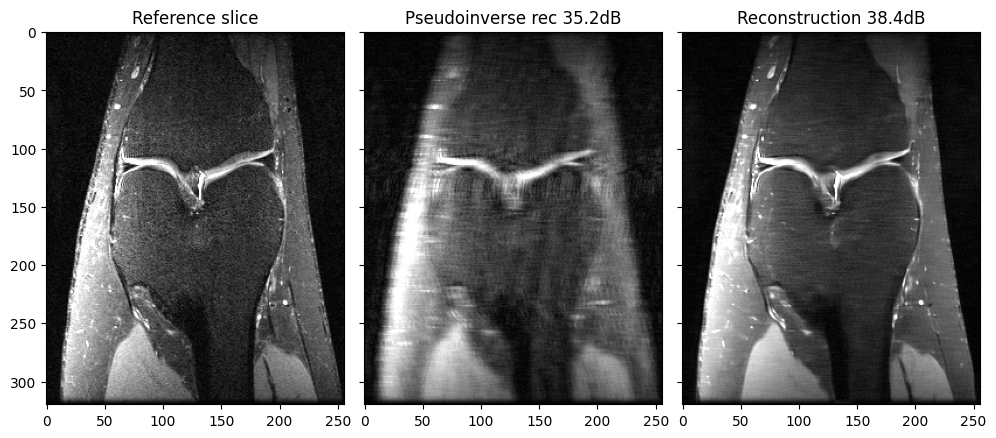

In [17]:
# perform reconstruction using your variational loss
rec = perform_reconstruction(variational_loss, measurement=masked_kspace, complex_target=complex_target, lr=0.1, iterations=500, seed=0)
plot_reconstruction(rec, complex_target)